
<h1 style="display:none;">
<h1 style="display:none;">
<h1 style="display:none;">
<h1 style="display:none;">
<h1 style="display:none;">
<h1 style="display:none;">
<h1 style="display:none;">
<h1 style="display:none;">
<h1 style="display:none;">
<h1 style="display:none;">

# Introduction to Computing for Engineers and Computer Scientists<BR><BR>HW2

## Questions, Discussion

### From Class

### Piazza

## Interactive and Overall Code Structure

Three observations:
1. All of the simulation functions, e.g. computing mu, sigma, daily return, random years, etc. are in a module "monte2" that the driving program imports and calls.<br><br>
1. The "main" program is stock_main. When the programs starts,
    1. It determines if it is running interactively or from the command line.
    1. Based on the determination, the program
        1. Prompts for inputs if interactive.
        1. Parses the command line parameters if running non-interactively.<br><br>
1. Two of the parameters are: plot_to_file and simulation_label. Assume the entered simulation label is "foo." If plot_to_file='Y' simulation writes the plots to "foo_years.png" and "foo_hist.png" instead of plotting to UI.


In [1]:
import monte2

In [6]:
import argparse
import json
import monte2
import matplotlib.pyplot as plt

# These should be private. Will cover later
# For numeric parameters, these are lower and upper bounds if there are bounds.
# For strings, these are constraints on values if there are any.
trading_days_lbound = 10
trading_days_ubound = 252
trading_years_lbound = 0
trading_years_ubound = 1000
bins_ubound = 20
bins_lbound = 10
valid_y_n = ["Y", "N"]
valid_tickers = ["AAPL", "GOOG", "AMZN"]

general_patience = 2

# Determines if the program is interactive or is running inside something
# like a Jupyter notebook.
def is_interactive():
    import __main__ as main
    return not hasattr(main, '__file__')


# Default is that the program is not interactive.
# Change from the prompt or a Jupyter cell if is interactive.
interactive = True
interactive = is_interactive()


# Inputs are a prompt string, the upper and lower bounds on the value and the
# number of failed attempts to tolerate.
def safe_get_int(prompt, lbound, ubound, patience):
    done = False
    result = None
    temp = None
    tries = 0

    # Loop until successful input or have exhausted all the tries.
    while (not done) and (tries <= patience):
        # The try ... except implements toleration for non-integer inputs.
        try:
            tries += 1
            temp = input(prompt + ":")
            temp = int(temp)
            if (temp < lbound) or (temp > ubound):
                print("Valid range is " + str(lbound) + " to " + str(ubound) + " Try again.")
            else:
                done = True
                result = temp
        except TypeError as ve:
            # Not an integer. Will try again.
            # Will print a specific error message.
            print("Input must be an integer.")
        except Exception as e:
            # Not sure what happened but will try again.
            print("Got an expected exception. Trying again.")

    # Did the function fail in getting a valid input?
    if not done:
        # Not my finest error message.
        print("Prepare to die fool!")
        raise ValueError

    return result


# Prompts for a string input. The inputs are:
# - prompt message
# - An optional list of valid inputs.
# - The number of base inputs to tolerate.
def safe_get_string(prompt, valid_values, patience):
    done = False
    result = None
    temp = None
    tries = 0

    # Loop until valid input or too many failed attempts.
    while (not done) and (tries <= patience):
        try:
            tries += 1
            temp = input(prompt + ":")
            if not temp in valid_values:
                print("Valid values are ", valid_values)
            else:
                done = True
                result = temp

        # Should narrow this exception to something more specific
        except Exception as e:
            print("Got exception. Trying again.")

    # Raise input value failure.
    if not done:
        print("Prepare to die fool!")
        raise ValueError

    return result


# Double checks all of the input parameters to ensure correctness.
# Input is a dictionary of parameter names and values.
def validate_args(args):
    result = True
    try:
        if args['trading_years'] is None or \
            args['trading_days'] is None or \
            args['bins'] is None or \
            args['ticker'] is None or \
            args['plot_to_file'] is None:
            result = False
            return result

        if args['trading_years'] > trading_years_ubound or args['trading_years'] < trading_years_lbound:
            result = False
            # This and the following error messages should be more complete, e.g. shows bounds.
            print("Trading years invalid.")
        elif args['trading_days'] > trading_days_ubound or args['trading_days'] < trading_days_lbound:
            result = False
            print("Trading days invalid.")
        elif args['bins'] > bins_ubound or args['bins'] < bins_lbound:
            result = False
            print("Bins invalid.")
        elif args['ticker'] not in valid_tickers:
            result = False
            print("Ticker invalid.")
        elif args['plot_to_file'] not in valid_y_n:
            result = False
            print("Plot to file invalid.")
    except Exception as e:
        print("Print something awful happened.",e)
        raise ValueError

    return result


# Gets and validates the input parameters that define the simulation.
def get_args():

    result = None

    # If the program is not interactive, parse the arguments.
    # The help messages should be more descriptive.
    if not interactive:
        parser = argparse.ArgumentParser(
            description='Monte Carlo GBM simulation of stock price evolution..')
        parser.add_argument('--ticker', default=None, type=str, metavar='str',
                            help='Ticker to simulate')
        parser.add_argument('--trading_days', default=None, type=int, metavar='int',
                            help='Number of trading days per year.')
        parser.add_argument('--trading_years', default=None, type=int, metavar='int',
                            help='Number of random years to simulate.')
        parser.add_argument('--bins', default=20, type=int, metavar='int',
                            help='Number of bins for return histogram')
        parser.add_argument('--plot_to_file', default="no", type=str, metavar='str',
                            help='Write charts to file?')
        parser.add_argument('--simulation_label', default="default", type=str, metavar='str',
                            help='Label for simulation.')
        args = parser.parse_args()
        result = vars(args)
    else:
        # The program is interactive. Will use prompts.
        result = {}

        # Notice that the code below is very highly patterned. I could simply into a parameterized procedures
        # that incorporates the two steps, which would be less error prone.
        temp = safe_get_string("Enter ticker:", valid_tickers, general_patience)
        result = {"ticker": temp}

        temp = safe_get_int("Enter no. of trading days", trading_days_lbound, trading_days_ubound, general_patience)
        result['trading_days'] = temp

        temp = safe_get_int("Number of years to simulate", trading_years_lbound, \
                            trading_years_ubound, general_patience)
        result['trading_years'] =  temp

        temp = safe_get_int("Enter no. of histogram bins", bins_lbound, bins_ubound,general_patience)
        result['bins'] = temp

        temp = input("Plot to file (Y/N):")
        result['plot_to_file'] = temp

        temp = input("Simulation label:")
        result['simulation_label'] = temp

    return result


# Plots the yearly returns
# If n is not none, this is the file to plot to.
def year_plot(yy,n):
    for i in range(0, len(yy)):
        plt.plot(yy[i])

    if n is not None:
        plt.savefig(n)
    else:
        plt.show()

    plt.close()


# Plots the histogram of returns
# If n is not none, this is the file to plot to.
def histo_return(yy, b, n):
    r = []
    for i in range(0,len(yy)):
        t = yy[i]
        t = t[-1]
        r.append(t)

#    print(r)
    plt.hist(r,b)
    if n is not None:
        plt.savefig(n)
    else:
        plt.show()

    plt.close()


def run_simulation(args):
    print("Running simulations with parameters:\n")
    print(json.dumps(args,indent=2))
    result = monte2.run_simulations(args['ticker'], args['trading_days'], args['trading_years'])

    if args['plot_to_file'] == 'Y':
        fy = args['simulation_label'] + "_years.png"
        fh = args['simulation_label'] + "_histo.png"
    else:
        fy = None
        fh = None

#    print("Years = ", result)
    year_plot(result, fy)
    histo_return(result, args['bins'], fh)

    return result


# This module should/could be callable from other main programs. The other main programs may pass in parameters.
def configure_and_run_simulation(args):
    if validate_args(args):
        run_simulation(args)
    else:
        raise ValueError("Invalid input parameters.")


# The main program if the simulation is running standalone.
def run_it():
    args = get_args()
    if validate_args(args):
        print("On the way.")
        run_simulation(args)
    else:
        print("Got an error.")


#interactive = True
#run_it()

if not interactive:
    run_it()

- The call below invokes the program above.


- The program detects that it is in interactive mode and prompts for user input.

Enter ticker::AAPL
Enter no. of trading days:252
Number of years to simulate:500
Enter no. of histogram bins:20
Plot to file (Y/N):N
Simulation label:I1
On the way.
Running simulations with parameters:

{
  "ticker": "AAPL",
  "trading_days": 252,
  "trading_years": 500,
  "bins": 20,
  "plot_to_file": "N",
  "simulation_label": "I1"
}
Mu =  -0.00115797819701
Sigma =  0.009253189893583315
Start price =  167.779999


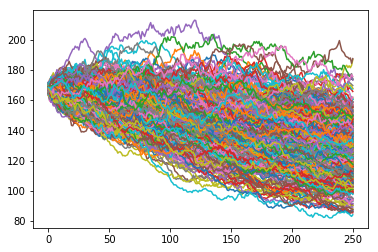

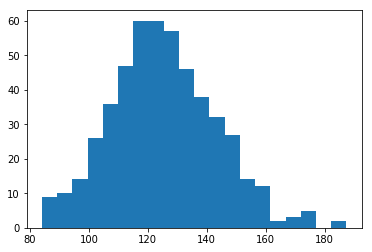

In [7]:
run_it()

- The screen capture below shows
    - Running directly from the command line.
    - Plotting the graphs to a file.
    

__Monte2 Library__

- Module/library that does the main work for the simulation.


- Does not care how/where the configuration information comes from, or where the plots go.


- An outer program controls where the plot goes, how the parameters get set, etc.


In [ ]:
def compute_relative_changes(a_list):
    result = []

    for i in range(1,len(a_list)):
        rel = (a_list[i] - a_list[i-1])/a_list[i-1]
        result.append(rel)

    return result


def compute_mean(a_list):
    total = 0;

    for i in range(0,len(a_list)):
        total = total + a_list[i]

    result = total / (len(a_list)+1)
    return result


def compute_std_deviation(avg, data):
    total = 0
    for k in range(0,len(data)):
        total = total + (data[k]-avg)**2

    result = math.sqrt(total/(len(data)-1))
    return result


def get_data_from_file(ticker):
    f_name = ticker + ".csv"
    r = pd.read_csv(f_name, delimiter=",")
    return r


def next_price(p, mu, sigma):
    r = np.random.normal(0,1)

    delta_p = mu*p + r*sigma*p
    p = p + delta_p

    return p


def generate_random_year(start_p, mu, sigma, days):
    result = []
    for j in range(0,days-1):
        start_p = next_price(start_p, mu, sigma)
        result.append(start_p)

    return result


def run_simulations(ticker, days, years):
    df = get_data_from_file(ticker)
    prices = df['Adj Close']
    relative_changes = compute_relative_changes(prices)
    mu = compute_mean(relative_changes)
    sigma = compute_std_deviation(mu, relative_changes)
    start_p = float(prices.tail(1))
    print("Mu = ", mu)
    print("Sigma = ", sigma)
    print("Start price = ", start_p)
    each_year = []

    for i in range(0,years):
        y = generate_random_year(start_p, mu, sigma, days)
        each_year.append(y)

    return each_year

In [9]:
import pandas

In [51]:
df = pandas.read_csv('AAPL.csv')
adj_close = df['Adj Close']
print("len(adj_close) = ", len(adj_close))

len(adj_close) =  22


In [52]:
start_price = adj_close[21]
print("start_p = ", start_price)
print("The 5th addjusted close = ", adj_close[4])

start_p =  167.779999
The 5th addjusted close =  174.350006


In [53]:
sum = 0
for i in range(0,len(adj_close)):
    sum += adj_close[i]

print("The total is = ", sum)

The total is =  3821.889986


In [ ]:
sum = 0

In [1]:
import csv
csvfile = open('AAPL.csv')
print("What does the CSV file look like?")
csvr = csv.reader(csvfile, delimiter=',')
print("The first row is ", csvr[0])

What does the CSV file look like?


TypeError: '_csv.reader' object is not subscriptable

In [55]:
print('Darn. Not a list.')
r = next(csvr)
print("r = ", r)
r = next(csvr)
print("r = ", r)
print("OK, it is iterable. But I get rows, AND I cannot index using 'Adj Close'")

Darn. Not a list.
r =  ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
r =  ['2018-01-02', '170.16000400000001', '172.300003', '169.259995', '172.259995', '172.259995', '25555900']
OK, it is iterable. But I get rows, AND I cannot index using 'Adj Close'


In [59]:
# Need to reopen because I did a couple nexts. Let's start from begining.
csvfile = open('AAPL.csv')

csvr2 = csv.reader(csvfile, delimiter=',')
sum = 0
# Have to call next() onces to skip the header line
r = next(csvr2)
for r in csvr2:
    sum += float(r[5])
    
print("Sum = ", sum)

Sum =  3821.889986


In [62]:
import math
import pandas as pd
import numpy as np



# This function takes a ticker symbol and loads a data frame
# with the data stored in a CSV file in the current directory.
def get_data_from_file(ticker):
    f_name = ticker + ".csv"
    df = pd.read_csv(f_name, delimiter=",")
    return df

# reading ticker data from AAPL
d1 = get_data_from_file('AAPL')

aapl_ac = d1['Adj Close']

# This function will calculate mu using the adj close part of the aapl file
def find_mu(adj_close_ticker):

    count = len(adj_close_ticker) #setting count as length of data string
    d = 0
    sum = 0
    for i in range(1, count):
        #j = i + 1
        relative_change = ((adj_close_ticker[i] - (adj_close_ticker[i-1]))/adj_close_ticker[i-1])
        d = d + 1
        sum = sum + relative_change
    print("d = ", d)
    print("sum = ", sum)
    mu_avg = sum/d
    return mu_avg


mu_final = find_mu(aapl_ac)
print("final_mu = ", mu_final)


d =  21
sum =  -0.0254755203342
final_mu =  -0.00121312001591
